## Trajectory as Time Series data


In [2]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

In [3]:
df = pd.read_csv('steps_train.txt', skiprows=1,nrows=110, header=None, usecols=[1,2])
df_test = pd.read_csv('steps_test.txt', skiprows=1, nrows=150, header=None, usecols=[1,2])

In [4]:
len(df)

110

In [5]:
x = np.array([[1,2,3,4,3,2,2,4,3,2]])
StandardScaler().fit_transform(x)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Displaying the trajectory

In [ ]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Training Trajectory","Testing Trajectory"))
fig.add_trace(go.Scatter(x=df[1], y=df[2], marker_color='blue', 
                         name="Training path"),row=1, col=1)
fig.add_trace(go.Scatter(x=df_test[1], y=df_test[2], marker_color='red',
                        name="Testing Score"),row=2, col=1)

fig.update_layout(showlegend=False)

In [7]:
fig.show()

In [7]:
x_values

array([[-0.        , -0.00043565, -0.00054456, ..., -0.        ,
        -0.00043565, -0.00054456]])

In [8]:
y_values

array([[ 0.00000000e+00, -5.20413377e-05,  1.66532281e-03, ...,
         0.00000000e+00, -5.20413377e-05,  1.66532281e-03]])

In [17]:
repeat = 10
x_values = (list(df[1]) * repeat)
y_values = (list(df[2]) * repeat)

fig1 = go.Figure(layout=go.Layout(showlegend=True))
fig1.add_trace(go.Scatter(y=x_values, name='X-coordinate', opacity=0.2,
                            marker=dict(size=1,color='red')))
fig1.add_trace(go.Scatter(y=y_values, name='Y-coordinate', opacity=0.2,
                            marker=dict(size=1,color='red')))

# Naive Approach-finding average value of x and y coordinate
average_values = ([(a+b)/2 for a,b in zip(x_values,y_values)])
fig1.add_trace(go.Scatter(y=average_values,  name='Average of X and Y', opacity=0.4,
                            marker=dict(size=1,color='green')))

#Dimensionality reduction using non-linear methods
tsne = manifold.TSNE(n_components=1, init='pca', random_state=0)
tsne_values = tsne.fit_transform(pd.DataFrame([x_values, y_values]).T).ravel()
# tsne_values = normalize([tsne_values])
fig1.add_trace(go.Scatter(y=list(tsne_values),  name='tSNE values '))
fig1.show()

In [31]:
pd.DataFrame([x_values, y_values]).T.shape

(1100, 2)

In [81]:
tsne = manifold.TSNE(n_components=1, init='pca', random_state=0)
tsne_values = tsne.fit_transform(pd.DataFrame([x_values, y_values]).T)

In [84]:
tsne_values.ravel().shape

(1100,)

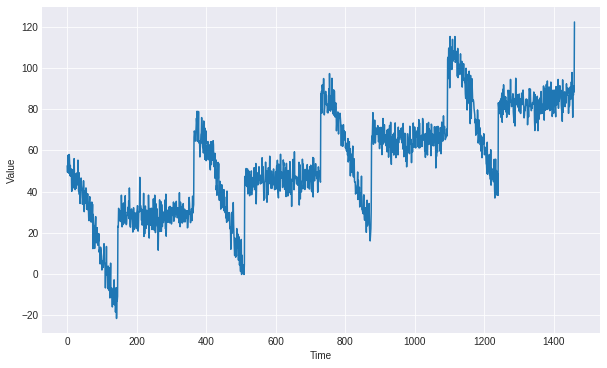

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.style.use('ggplot')
plt.show()

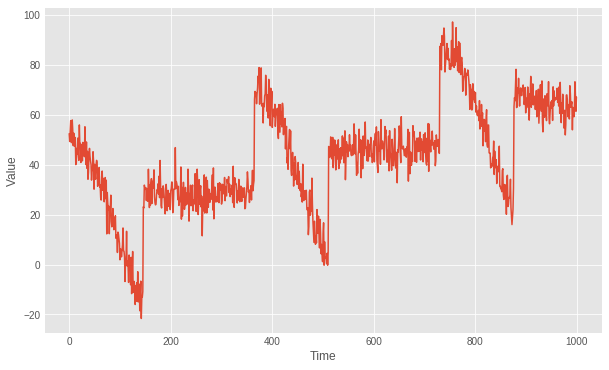

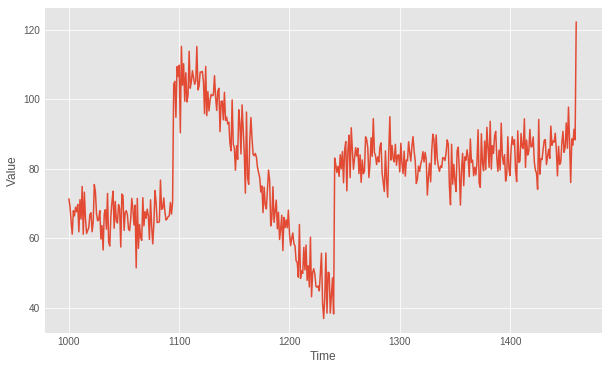

In [35]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [36]:
naive_forecast = series[split_time - 1:-1]

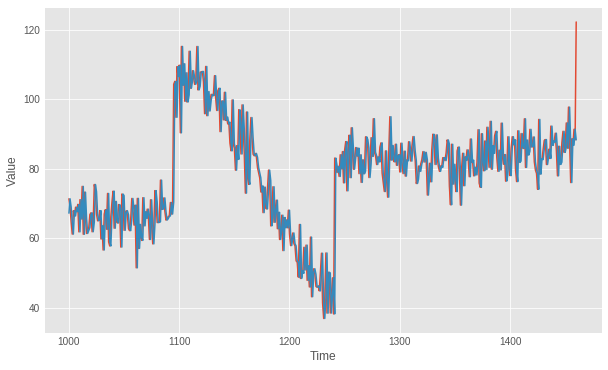

In [37]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

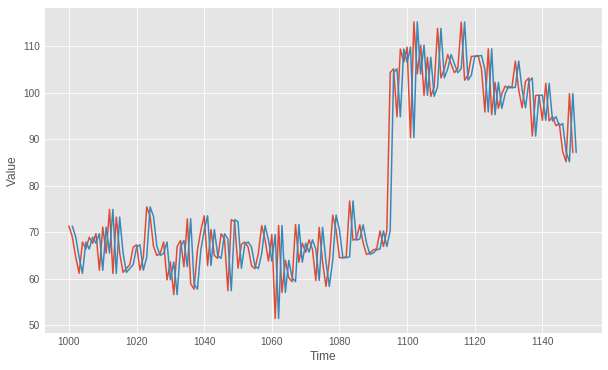

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [39]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


In [40]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

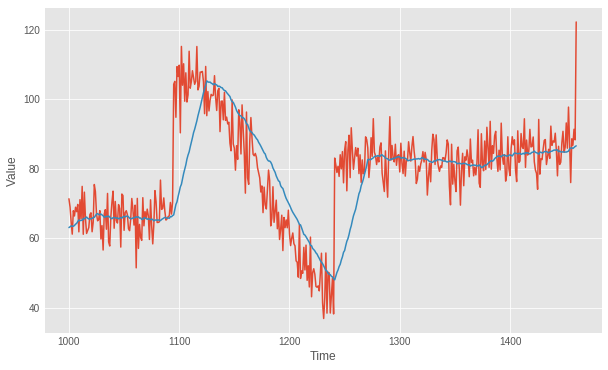

In [41]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [42]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


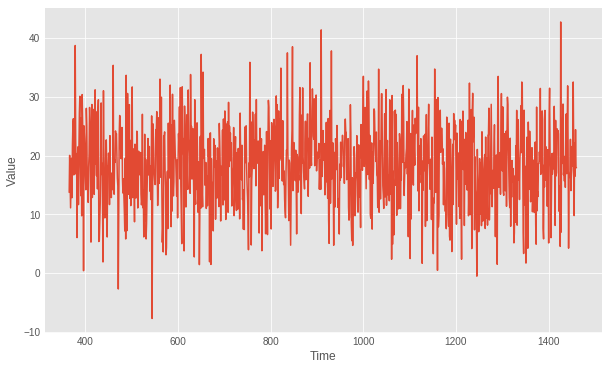

In [43]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

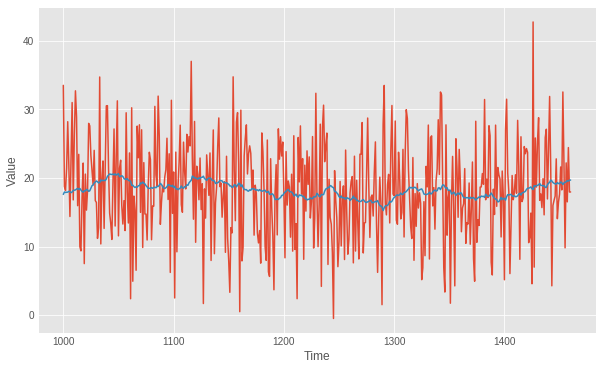

In [44]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

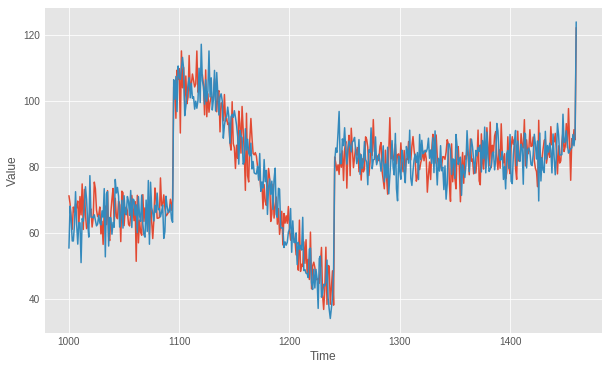

In [45]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

## Metrics

#### Errors - forecasts - actual

    Difference with actual and predicted. 

#### MSE = np.square(errors).mean()
    Squaring for removing negative values.
    

#### rmse = np.sqrt(mse)
    If mean is to be of same scale as of errors

#### mae = np.abs(errors).mean()
    Mean absolute Error. Also called (mean absolute deviation MAD). It does not penalize the large errors. Gain or Loss of error is just proportional to the size of the error

#### mape = np.abs(errors / x_valid).mean()
    Mean absolute percentage error. This is mean ration between absolute error and absolute value. This gives idea about size of the errors compared to values. 
    
#### Moving Agerage
    Concept of averaging window. example 30 days. It nicely eliminate the noise, but does not consider trend or seasonality. Common and simple approach for forecasting. Forecast will be in the future window mean. But this does not yeild a good result as the time series will have trend and seasonality.
    
#### Differencing
    Removing the trend and sesonality from the time series. Instead of studying the time series itself. We study the difference between value at time t and the value at an earlier period. This removes, trend and sesonality from the time series. Then use a moving average on differenced time series. To get final forecast, we need to restore the trend and seasonality by adding back the values subtracted earlier and then apply moving average. This is slightly better. 
    

    

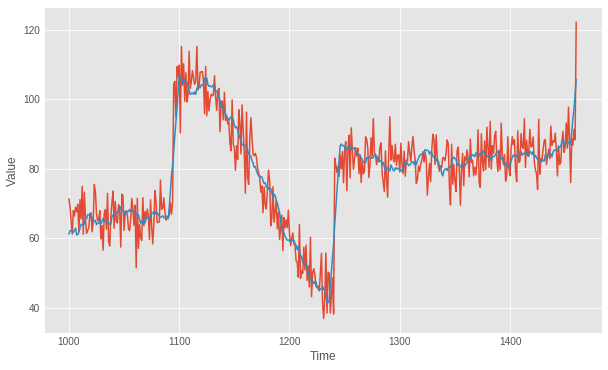

In [46]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [47]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452263
4.569442


### Applying Neural Networks to Time Series Data

In [55]:
dataset = tf.data.Dataset.range(20)
for val in dataset:
    print(val.numpy(), end= ' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [56]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window in dataset:
    for val in window:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [51]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window in dataset:
    for val in window:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [59]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [64]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [65]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=20)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[1 2 3 4] [5]
[0 1 2 3] [4]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [73]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=20)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print('x = ', x.numpy())
    print('y = ', y.numpy())

x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]
x =  [[3 4 5 6]
 [1 2 3 4]]
y =  [[7]
 [5]]
x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
